In [1]:
import pandas as pd
import numpy as np

from surprise import accuracy, Dataset, SVD, Reader, dump
from surprise.model_selection import train_test_split, cross_validate

import string

food_data = pd.read_csv('data/food.csv')
ratings_data = pd.read_csv('data/ratings.csv')

def text_cleaning(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text
food_data['Describe'] = food_data['Describe'].apply(text_cleaning)

def create_soup(x):
  return " ".join([x['Describe'], x['C_Type'], x['Veg_Non']])

food_data['soup'] = food_data.apply(create_soup, axis=1)

reader = Reader(rating_scale=(1, 10))

merged_data = pd.merge(ratings_data, food_data, on='Food_ID')
data = Dataset.load_from_df(merged_data[['User_ID', 'Food_ID', 'Rating']], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# We'll use the famous SVD algorithm.
algo = SVD(random_state=42)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 2.9822


2.982221932594881

In [28]:
cv = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.7689  2.9140  2.9614  2.8376  3.0491  2.9062  0.0970  
MAE (testset)     2.3944  2.5111  2.4772  2.4214  2.6909  2.4990  0.1043  
Fit time          0.01    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [29]:
predictions

[Prediction(uid=32.0, iid=143.0, r_ui=1.0, est=5.212655831012134, details={'was_impossible': False}),
 Prediction(uid=93.0, iid=130.0, r_ui=5.0, est=6.139087593755592, details={'was_impossible': False}),
 Prediction(uid=63.0, iid=269.0, r_ui=3.0, est=6.270845390478057, details={'was_impossible': False}),
 Prediction(uid=13.0, iid=74.0, r_ui=8.0, est=5.781941520715908, details={'was_impossible': False}),
 Prediction(uid=6.0, iid=22.0, r_ui=5.0, est=4.968261535443404, details={'was_impossible': False}),
 Prediction(uid=94.0, iid=48.0, r_ui=3.0, est=5.504209087916219, details={'was_impossible': False}),
 Prediction(uid=11.0, iid=200.0, r_ui=10.0, est=5.6761855890991635, details={'was_impossible': False}),
 Prediction(uid=86.0, iid=159.0, r_ui=2.0, est=5.130810509409138, details={'was_impossible': False}),
 Prediction(uid=100.0, iid=24.0, r_ui=10.0, est=5.143433985963666, details={'was_impossible': False}),
 Prediction(uid=41.0, iid=4.0, r_ui=6.0, est=5.426484663470089, details={'was_impos

Demonstration about how to predict the rating for the user with id=80 and item with id=2

In [30]:
algo.predict(80.0, 2.0)

Prediction(uid=80.0, iid=2.0, r_ui=None, est=6.161212619049724, details={'was_impossible': False})

In [39]:
user_id = 4.0

def get_user_recommendations(user_id, n=5):
    predictions = []
    for item in merged_data['Food_ID'].unique():
        predictions.append(algo.predict(user_id, item))
    
    best_items = sorted([(prediction.iid, prediction.est) for prediction in predictions], key=lambda x: x[1])[::-1][:n]
    best_items_idx = [x for x, y in best_items]
    rec_items = food_data.loc[best_items_idx]
    return rec_items['Name']

print(get_user_recommendations(user_id, n=5))

212    berry parfait hazelnut white chocolate sable
200          mix fruit laccha rabri tortilla crunch
127                                 thai lamb balls
188                                 easy bread poha
48                             christmas tree pizza
Name: Name, dtype: object


## Fine-tuning

In [32]:
from surprise.model_selection import GridSearchCV

param_grid = {
  'n_factors': [20, 50, 100, 200, 400, 800, 1000],
  'n_epochs': [5, 10, 20, 50, 100, 200]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.8493328359206425
{'n_factors': 800, 'n_epochs': 5}


In [33]:
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']

# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch, random_state=42)

# Train the algorithm on the trainset
svd.fit(trainset)

In [34]:
cv = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.7234  2.9067  2.9852  2.8775  2.9123  2.8810  0.0865  
MAE (testset)     2.3403  2.5172  2.5607  2.4985  2.4900  2.4813  0.0746  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


### Analyzing predictions

In [35]:
predictions = svd.test(testset)
predictions

[Prediction(uid=32.0, iid=143.0, r_ui=1.0, est=3.8740361193418824, details={'was_impossible': False}),
 Prediction(uid=93.0, iid=130.0, r_ui=5.0, est=4.976564548008135, details={'was_impossible': False}),
 Prediction(uid=63.0, iid=269.0, r_ui=3.0, est=4.311405417625729, details={'was_impossible': False}),
 Prediction(uid=13.0, iid=74.0, r_ui=8.0, est=5.142429841234285, details={'was_impossible': False}),
 Prediction(uid=6.0, iid=22.0, r_ui=5.0, est=5.066880885118487, details={'was_impossible': False}),
 Prediction(uid=94.0, iid=48.0, r_ui=3.0, est=4.35024065248207, details={'was_impossible': False}),
 Prediction(uid=11.0, iid=200.0, r_ui=10.0, est=5.378289425667743, details={'was_impossible': False}),
 Prediction(uid=86.0, iid=159.0, r_ui=2.0, est=3.867190647709191, details={'was_impossible': False}),
 Prediction(uid=100.0, iid=24.0, r_ui=10.0, est=5.344717160221997, details={'was_impossible': False}),
 Prediction(uid=41.0, iid=4.0, r_ui=6.0, est=5.598493007086816, details={'was_imposs

In [36]:
ratings = {k: 0 for k in range(1, 10+1)}

for pred in predictions:
    ratings[round(pred.est)]+=1

ratings

{1: 0, 2: 0, 3: 2, 4: 26, 5: 50, 6: 22, 7: 28, 8: 0, 9: 0, 10: 0}

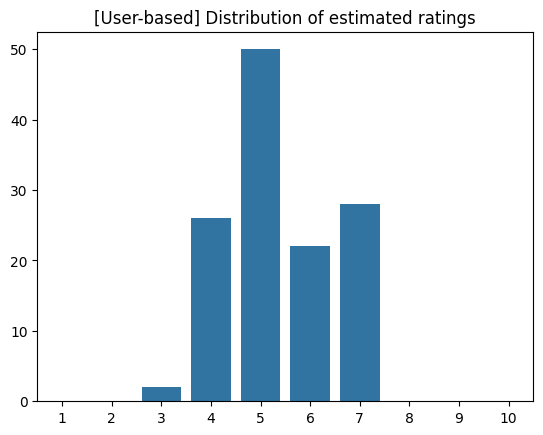

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(ratings)
plt.title("[User-based] Distribution of estimated ratings");

## Save the model in a directory

In [41]:
import os
dump.dump(os.path.join('models', 'ub_model.dump'), algo=svd)

## Load the model and predict

In [11]:
import os
_, algo = dump.load(os.path.join('models', 'ub_model.dump'))

In [15]:
user_id = 91.0

def get_user_recommendations(user_id, algo, n=5):
    predictions = []
    for item in merged_data['Food_ID'].unique():
        predictions.append(algo.predict(user_id, item))
    
    best_items = sorted([(prediction.iid, prediction.est) for prediction in predictions], key=lambda x: x[1])[::-1][:n]
    best_items_idx = [x for x, y in best_items]
    rec_items = food_data.loc[best_items_idx]
    return rec_items['Name']

print(get_user_recommendations(user_id, algo, n=5).values)

['chicken dong style' 'chocolate nero cookies' 'detox haldi tea'
 'bread chana basket' 'kolim / jawla']
